# Building a CamScanner like Document Scanner using OpenCV library

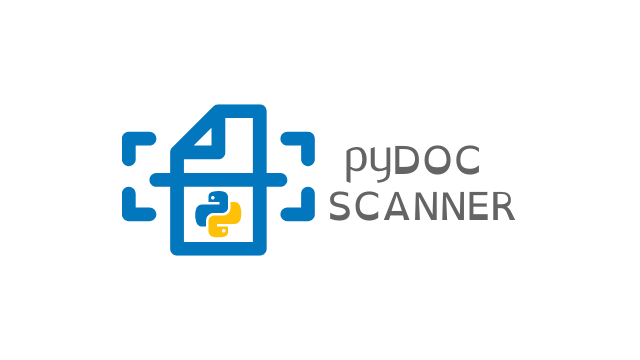

**By Shashank Malhotra<br>
CSE 7th<br>
1916190**

### Importing Libraries

In [1]:
import numpy as np
import imutils
import cv2
from skimage.filters import threshold_local
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,10]

### Reading the image

In [2]:
image = cv2.imread('./bill.jpg')

### Computing the ratio of the old height to the new height, cloning it, and resizing it

In [3]:
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height=500)

### Displaying the image

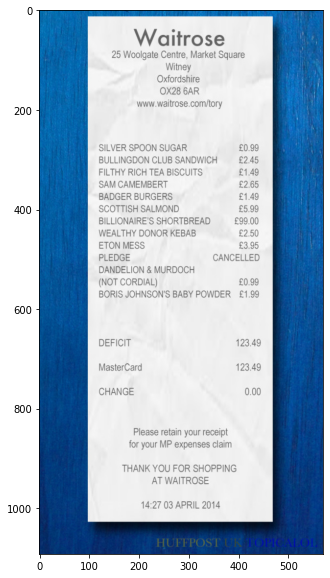

In [4]:
plt.imshow(orig)

### Converting the image into grayscale

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### Applying Gaussian Smoothing (to remove noise from the image)

In [6]:
gray = cv2.GaussianBlur(gray, (5,5), 0)

### Finding Edges in the Image

In [7]:
edged = cv2.Canny(gray, 75, 200) # minVal, maxVal

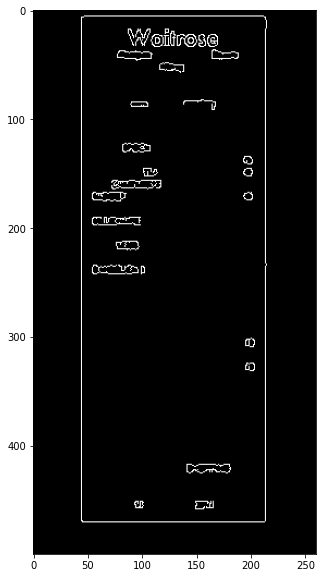

In [8]:
dispImage = cv2.cvtColor(edged.copy(), cv2.COLOR_GRAY2RGB)
plt.imshow(dispImage)

### Finding contour (retriving contour list), keeping only the largest five & initializing the screen contour

In [9]:
contours = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]

for c in contours:
    perimeter = cv2.arcLength(c, True) # (curve, closed = True/False)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    
    # if our approximated contour has four points
    if len(approx) == 4:
        screenContour = approx
        break

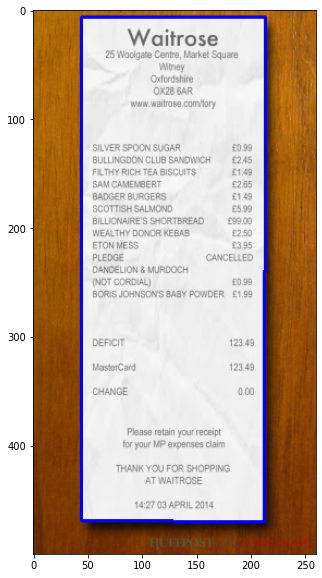

In [10]:
cv2.drawContours(image, [screenContour], -1, (255,0,0), 2) # -1 => draw all contours, (color), thickness
dispImage = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
plt.imshow(dispImage)

In [11]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    # the top-left point will have the smallest sum, whereas the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # the top-right point will have the smallest difference, whereas the bottom-left will have the largest 
    # difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [12]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them individually
    rect = order_points(pts)
    
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image, which will be the maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image, which will be the maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    destinationPoints = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype = "float32")
    
    # compute the perspective transform matrix and then apply it
    mapped = cv2.getPerspectiveTransform(rect, destinationPoints)
    warped = cv2.warpPerspective(image, mapped, (maxWidth, maxHeight))
    
    return warped

### Applying the four point transform to obtain a top-down view of the original image


In [13]:
warped = four_point_transform(orig, screenContour.reshape(4, 2) * ratio)

### Converting the warped image to grayscale, then threshold it to give it that 'black and white' paper effect

In [14]:
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255

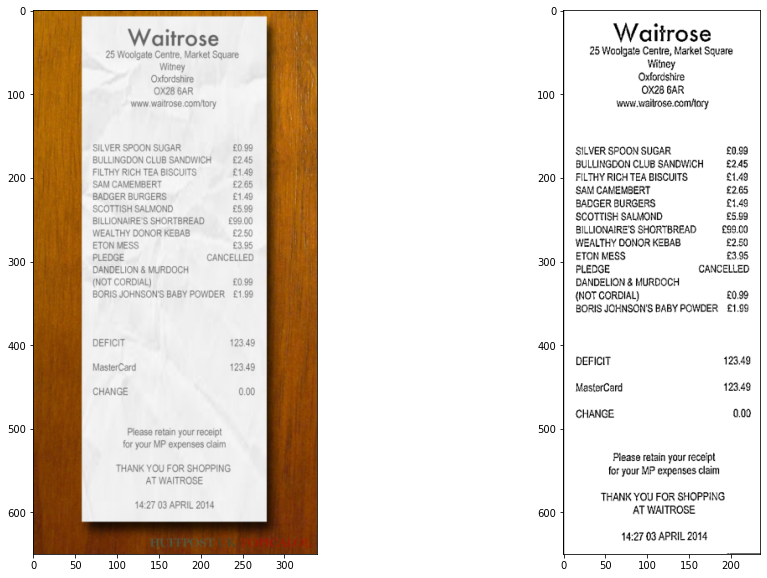

In [15]:
origImage = imutils.resize(orig, height = 650)
dispImage = imutils.resize(warped, height = 650)
dispImage = cv2.cvtColor(dispImage, cv2.COLOR_GRAY2RGB)
origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)
plt.imshow(origImage)
plt.subplot(1, 2, 2)
plt.imshow(dispImage)
plt.show()